# Задача

### Обучить сиамскую сеть для верификации лиц на датасете LFW

In [11]:
%tensorflow_version 2.x

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

Загрузка и подготовка датасета LFW



In [13]:
(train_ds, test_ds), ds_info = tfds.load(
    name='lfw',
    as_supervised=True, with_info=True, 
    split=['train[:90%]', 'train[90%:]']
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteEU79YJ/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


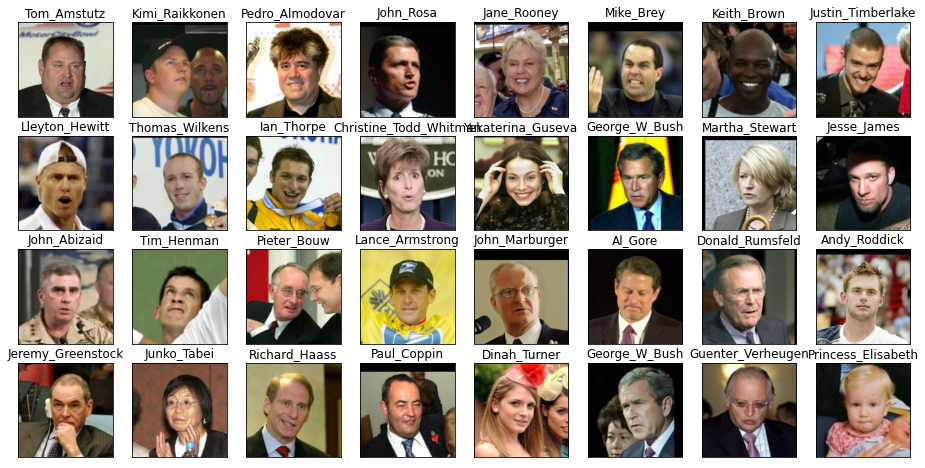

In [24]:
fig = plt.figure(figsize=(16, 8))

for j, (labels, images) in enumerate(iter(train_ds.take(32))): 
    numpy_images = images.numpy()
    #numpy_labels = labels.numpy()
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(numpy_images)
    plt.xticks([]), plt.yticks([])
    plt.title(labels.numpy().decode("utf-8"))
plt.show()

In [25]:
train_images = list()
train_labels = list()

for (label, image) in iter(train_ds):
  train_labels.append(label.numpy().decode("utf-8"))

train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

In [26]:
popular_arr = list()
uniq, count = np.unique(train_labels, return_counts =True)
for i in range(len(uniq)):
  popular_arr.append([uniq[i], count[i]])
popular_arr.sort( key = lambda x: x[1], reverse=True)
test_popular_arr = popular_arr[500:505]
popular_arr = popular_arr[:500]
test_popular_person = [i[0] for i in test_popular_arr]
popular_person = [i[0] for i in popular_arr]

In [27]:
train_images = list()
train_labels = list()

for (label, image) in iter(train_ds):
  if label.numpy().decode("utf-8") in popular_person:
    train_images.append(image)
    train_labels.append(label.numpy().decode("utf-8"))


train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

test_images = list()
test_labels = list()

for (label, image) in iter(train_ds):
  if label.numpy().decode("utf-8") in test_popular_person:
    test_images.append(image)
    test_labels.append(label.numpy().decode("utf-8"))


test_images = np.array(test_images, dtype='float32')
test_labels = np.array(test_labels)

In [29]:
train_images.shape

(5705, 250, 250, 3)

In [28]:
train_labels.shape

(5705,)

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
print(train_ds)

<TensorSliceDataset shapes: ((250, 250, 3), ()), types: (tf.float32, tf.string)>


In [31]:
INP_SIZE = 250
NUM_EPOCHS = 10
BATCH_SIZE = 64

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.repeat(NUM_EPOCHS)

In [32]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [33]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [34]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [35]:
for iteration, (data) in enumerate(train_ds):
    images, labels = data[0], data[1]
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 94.3575210571289
[50] Loss: 2.638430595397949
[100] Loss: 1.6618109941482544
[150] Loss: 0.16536414623260498
[200] Loss: 32.47040939331055
[250] Loss: 0.16696631908416748
[300] Loss: 4.12323522567749
[350] Loss: 1.1763324737548828
[400] Loss: 0.2714483439922333
[450] Loss: 7.321784496307373
[500] Loss: 5.817651271820068
[550] Loss: 0.011927317827939987
[600] Loss: 0.9788006544113159
[650] Loss: 0.5309412479400635
[700] Loss: 9.113646507263184
[750] Loss: 4.218038558959961
[800] Loss: 0.35735946893692017
[850] Loss: 0.553416907787323


In [36]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

def prepare_img(img):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)).numpy()

def diff_img(img1, img2):
  fig = plt.figure(figsize=(8, 6))

  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(img1.astype('int'))

  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(img2.astype('int'))

  plt.show()

  img1 = prepare_img(img1)
  img2 = prepare_img(img2)

  img1_emb = model(img1.reshape(1, INP_SIZE, INP_SIZE, 3))
  img2_emb = model(img2.reshape(1, INP_SIZE, INP_SIZE, 3))

  return diff(img1_emb, img2_emb)

In [37]:
test_labels

array(['Rebecca_Romijn-Stamos', 'Raoul_Ruiz', 'Rebekah_Chantay_Revels',
       'Rebekah_Chantay_Revels', 'Queen_Rania', 'Rebekah_Chantay_Revels',
       'Rainer_Schuettler', 'Rainer_Schuettler', 'Queen_Rania',
       'Rainer_Schuettler', 'Raoul_Ruiz', 'Rebecca_Romijn-Stamos',
       'Rebecca_Romijn-Stamos', 'Raoul_Ruiz', 'Queen_Rania',
       'Queen_Rania', 'Raoul_Ruiz', 'Rebekah_Chantay_Revels',
       'Rebecca_Romijn-Stamos', 'Rainer_Schuettler'], dtype='<U22')

In [38]:
np.where(test_labels == 'Raoul_Ruiz')

(array([ 1, 10, 13, 16]),)

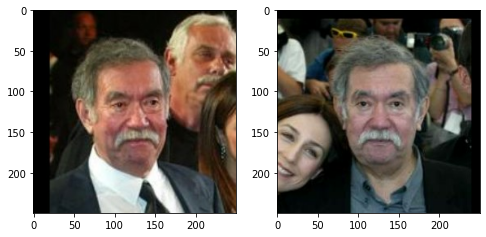

15.156707064628806

In [42]:
diff_img(test_images[10], test_images[13])

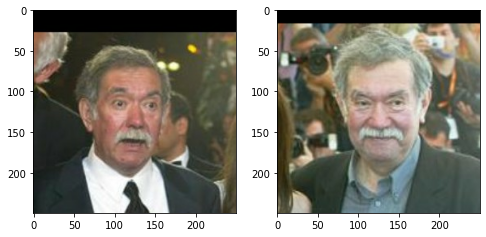

11.315994987349143

In [43]:
diff_img(test_images[1], test_images[16])

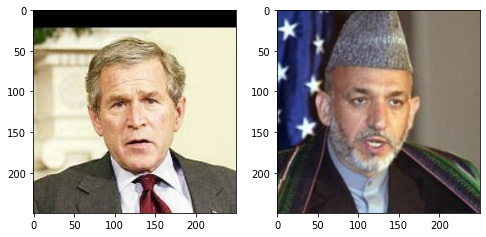

15.769873780959148

In [46]:
diff_img(train_images[56], train_images[456])